In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

In [11]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation

#validation
from src.validation import metrics
from src.validation import metrics_description

#sklearn
from sklearn.model_selection import GroupKFold

In [12]:
%%time
df_training,features,target = make_dataset.get_data(nrows=10000,
                                                    low_memory=True, 
                                                    dataset="training", 
                                                    feather=True) #false on AWS/colab

low memory activated
Memory usage after optimization is: 6.16 MB
Decreased by 74.3%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 6.1+ MB
None
CPU times: user 2.94 s, sys: 1.16 s, total: 4.09 s
Wall time: 12.7 s


In [5]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="validation", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 65.86 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 65.4+ MB
None
CPU times: user 6.9 s, sys: 2.84 s, total: 9.75 s
Wall time: 9.65 s


### 2a Parte: Pycaret Linear Models

In [8]:
load_table = pd.read_excel("../../reports/pycaret_compare_results.xlsx", index=True)
load_table

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Bayesian Ridge,0.3020,0.1240,0.3522,0.0027,0.2461,0.4653,0.2890
1,Lasso Regression,0.3013,0.1247,0.3532,-0.0027,0.2468,0.4605,0.0351
2,Elastic Net,0.3013,0.1247,0.3532,-0.0027,0.2468,0.4605,0.0202
3,Lasso Least Angle Regression,0.3013,0.1247,0.3532,-0.0027,0.2468,0.4605,0.0297
4,AdaBoost Regressor,0.3038,0.1255,0.3543,-0.0091,0.2479,0.4716,0.7128
5,Random Forest,0.3075,0.1277,0.3573,-0.0267,0.2490,0.4806,5.4908
6,Orthogonal Matching Pursuit,0.3072,0.1278,0.3575,-0.0275,0.2493,0.4842,0.0358
7,Gradient Boosting Regressor,0.3075,0.1284,0.3583,-0.0320,0.2496,0.4799,3.9122
8,Extreme Gradient Boosting,0.3078,0.1285,0.3585,-0.0332,0.2496,0.4795,0.9406
9,Extra Trees Regressor,0.3122,0.1332,0.3650,-0.0712,0.2538,0.4926,4.4775


In [13]:
from sklearn.ensemble import RandomForestClassifier
rf_param_grid =  {
    'rf__n_estimators' : [10],
}


#encoding target to multiclass
#(df[target]*4).astype(int))
lab_enc = preprocessing.LabelEncoder()
encoded_target_train = lab_enc.fit_transform(df_training[target])


#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))


#scorer function
scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True, average='weighted')

result = evaluation.evaluate_model(df_training[features], encoded_target_train,
                                   RandomForestClassifier(), 'rf',
                                   rf_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=3,
                                   pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for rf model, 10000 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


ValueError: Invalid parameter rf for estimator RandomForestClassifier(). Check the list of available parameters with `estimator.get_params().keys()`.

In [15]:
lr_param_grid =  {
    'n_jobs' : [-1],

}

#model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model
reg = LinearRegression()


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'lr',
                                   lr_param_grid, 
                                   scorer, n_iter=1, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for lr model, 10000 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


==> Elapsed seconds: 3.531
Best lr model: LinearRegression(n_jobs=-1)
Best lr score (val): 0.130


NameError: name 'results' is not defined

### 3a parte metricas

In [14]:
model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

Qtde. eras: 22
performance over time


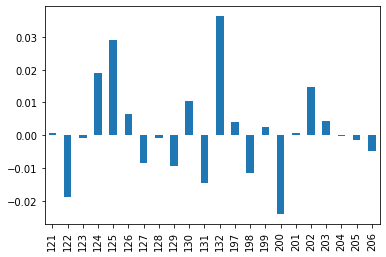

In [15]:
era_scores, era_df, df_metrics, feat_corrs = metrics.submission_metrics(df_validation, preds, model.name)

In [ ]:
feat_corrs.describe()

In [21]:
df_metrics

,Valor,Categoria,Range_Aceitavel,Descricao
Metrica,,,,
Model_Name,lr,Submission,NA,Nome do Modelo
Max_Drawdown,-0.05446,Financeira,[..],Perda máxima em uma era
Avg_corr,0.01592,Submission,[..],...
Median_corr,0.02376,Estatistica,[..],...
Variance,0.0008295,Estatistica,[..],...
Std_Dev,0.0288,Estatistica,[..],...
AR(1),-0.1373,Estatistica,[..],...
Skewness,-0.4416,Estatistica,[..],...
Exc_Kurtosis,-0.003025,Estatistica,[..],...


##### Metricas regressao (melhorar para o SP)

In [17]:
model = list(filter(lambda x: x[1] == 'lr', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

# Evaluate the model
print('Model performance on validation set:')
score = model.model.score(df_validation[features], df_validation[target])  #default deve ser o R2
mse = mean_squared_error(df_validation[target], preds)
print(f'Training R^2: {score}')
print(f'Training MSE: {mse}')

Model performance on validation set:
Training R^2: -0.010808492754463828
Training MSE: 0.12618499994277954


Qtde. eras: 22
performance over time


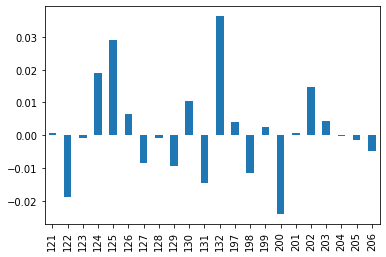

In [115]:
era_scores, era_df, df_metrics, feat_corrs = metrics.submission_metrics(df_validation, preds, model.name)

In [116]:
df_metrics

,Valor,Categoria,Range_Aceitavel,Descricao
Metrica,,,,
Model_Name,rf,Submission,NA,Nome do Modelo
Max_Drawdown,-0.02401,Financeira,[0%..2%],Perda máxima em uma era
Validation_Corr,0.001461,Submission,"[3.6%..4.4%] 4.8%, overfitting",Média spearman corr por era
Median_corr,0.0001883,Estatistica,[3.6%..4.4%] Dentro do range de médias,Mediana spearman corr por era
Variance,0.0001974,Estatistica,[0..] Próximo a zero,Variancia spearman corr por era
Std_Dev,0.01405,Estatistica,[0..] Próximo a zero,Std spearman corr por era
AR(1),-0.02083,Estatistica,[0..] Próximo a zero,AR(1) pearson corr eras[:-1] e eras[1:]
Skewness,0.6107,Estatistica,[0..1],"Skewness, central moment **3"
Exc_Kurtosis,0.374,Estatistica,[-1..0],Kurtosis central moment **4


Rascunho

### Local training

In [6]:
memory_usage.memory()

Available memory (%): 30.492687225341797


In [7]:
results, res_cv = list(), dict()

In [6]:
#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))

In [ ]:
rf_param_grid =  {
    'reg_rf__n_estimators' : [10],
}


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'reg_rf',
                                   lr_param_grid, 
                                   scorer, n_iter=1, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

In [ ]:
result[0].results

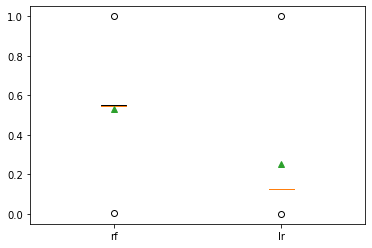

In [10]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [11]:
#salvando o pipeline completo
file_path = '../../models/sao_paulo-pipeline.pkl'

model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
model.save(file_path)

In [12]:
#salvando apenas o modelo
from joblib import dump, load
dump(model.model, '../../models/sao_paulo-baseline.pkl')

['../../models/sao_paulo-baseline.pkl']

In [13]:
#carregando o modelo
model_loaded = load(file_path)